<a href="https://colab.research.google.com/github/suhayb-h/Acute-Lymphoblastic-Leukemia-Classifier/blob/main/New_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This final notebook outlines building a transfer learning neural network to identify lymphoblasts as being cancerous or normal.

Transfer learning requires a pre-trained neural network to serve as a starting point in model construction. In the context of image classification, a ready-made model trained on a large and generalized dataset will serve as a generic model of the visual world. New layers can be added to the base model and only these new layers will be trained towards the specified task of interest. In the case of this project, the task is to correctly identify images in the ISBI-2019 dataset as cancerous or normal. As an analogy, the machine needs to be 'specialized' much like physicians, clinicians and scientists need to specialize their knowledge of the entire visual world towards interpreting images of cells and microscopic features.

A pre-trained image classifier model is a documented and openly available network that was previously trained on a extensive dataset of random images. For this project, a pre-trained model will be used directly from TensorFlow Hub, a repository of pre-trained TensorFlow models. Once a model has been loaded, new layers were added to allow for transfer learning to fine-tune the model to serve as an ALL classifier model.

There are two ways to customize the pre-trained model:

*   Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

*   Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

Data augmentation serves as a central principal that will be applied to all models in this project. The purpose of this practice was to increase the diversity of the training set by applying random, yet realistic, transformations to the dataset to create new images for the dataset. These transformations include image flipping and image rotation.

Compose the model

*   Load in the pretrained base model and corresponding pretrained weights
*   Stack the classification layers on top

In [1]:
import pandas as pd
import numpy as np
#import time
from sklearn.metrics import confusion_matrix


#import PIL.Image as Image
import matplotlib.pylab as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#import datetime

from google.colab import drive
drive.mount('/content/drive/')

#%load_ext tensorboard

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


TensorFlow hub has a variety of models available to be used for a variety of purposes. 154 models are available within this repository for image classification alone. When selecting for models trained on the largest possible generalized dataset (identified as the ImageNet ILSVRC dataset) and the most recent version of the TensorFlow library, 65 models were available. Of the myriad of model architectures available, the most complex and latest variant ResNet model was selected as the pre-trained model to be used for the ALL classifier. This model is the ResNet V2 152 model.

In [2]:
resnet_base = "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5"

classifier_base = \
  hub.KerasLayer(
      resnet_base, 
      input_shape = (480, 480, 3),
      trainable = False #Training base model won't yield significant improvements
      )

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  str('/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data'),
  validation_split = 0.175,
  labels = 'inferred',
  label_mode = 'categorical',
  class_names = ('hem', 'all'),
  color_mode = 'rgb',
  shuffle = True,
  subset = "training",
  seed = 42,
  image_size = (480, 480),
  batch_size = 100
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str('/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data'),
  validation_split = 0.175,
  labels = 'inferred',
  label_mode = 'categorical',
  class_names = ('hem', 'all'),
  color_mode = 'rgb',
  shuffle = True,
  subset = "validation",
  seed = 42,
  image_size = (480, 480),
  batch_size = 100
)

Found 10661 files belonging to 2 classes.
Using 8796 files for training.
Found 10661 files belonging to 2 classes.
Using 1865 files for validation.


In [23]:
train_ds.class_names

('hem', 'all')

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [6]:
# Weight calculation for normal lymphocytes:  
# Number of cancer cells divided by the number of normal cells.

7272/3389

2.145765712599587

In [7]:
# Weight of 2.15 is applied to 'hem' cells

weights = {0: 2.15,
           1: 1}

In [8]:
#This cell ensures the GPU is working optimally by ensuring data is delivered for the next step before the current step has finished
#AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
#for image_batch, labels_batch in train_ds:
#  print(image_batch.shape)
#  print(labels_batch.shape)
#  break

In [10]:
#feature_batch = classifier(image_batch)
#print(feature_batch.shape)

In [11]:
model_2 = tf.keras.Sequential([
  classifier_base,
  tf.keras.layers.Dense(2, 
                        activation = 'sigmoid') #Narrows the model to either 'all' or 'hem'
])

model_2.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss = 'CategoricalCrossentropy',
  metrics = 'CategoricalAccuracy')

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              60382697  
                                                                 
 dense (Dense)               (None, 2)                 2004      
                                                                 
Total params: 60,384,701
Trainable params: 2,004
Non-trainable params: 60,382,697
_________________________________________________________________


Train the model


In [12]:
#predictions = model(image_batch)
#predictions.shape

In [13]:
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#%tensorboard --logdir logs/fit

#tensorboard_callback = tf.keras.callbacks.TensorBoard(
#    log_dir = log_dir,
#    histogram_freq = 1) # Enable histogram computation for every epoch

#history_2 =\
model_2.fit(train_ds, 
            validation_data = val_ds, 
            epochs = 5, 
            class_weight = weights)
#           callbacks = tensorboard_callback)
model_2_df = pd.DataFrame(model_2.history)
path_2 =\
'/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data/model_2.csv'

with open(path_2, 'w', encoding = 'utf-8-sig') as f:
  model_2_df.to_csv(f)

Epoch 1/5
88/88 [==============================] - 938s 11s/step - loss: 0.7434 - categorical_accuracy: 0.7327 - val_loss: 0.5986 - val_categorical_accuracy: 0.6804
Epoch 2/5
88/88 [==============================] - 161s 2s/step - loss: 0.6524 - categorical_accuracy: 0.7833 - val_loss: 0.5346 - val_categorical_accuracy: 0.7249
Epoch 3/5
88/88 [==============================] - 161s 2s/step - loss: 0.6257 - categorical_accuracy: 0.7942 - val_loss: 0.4405 - val_categorical_accuracy: 0.7979
Epoch 4/5
88/88 [==============================] - 161s 2s/step - loss: 0.6152 - categorical_accuracy: 0.7998 - val_loss: 0.4570 - val_categorical_accuracy: 0.7877
Epoch 5/5
88/88 [==============================] - 161s 2s/step - loss: 0.6195 - categorical_accuracy: 0.8001 - val_loss: 0.3962 - val_categorical_accuracy: 0.8273


In [14]:
model_2_df = \
pd.read_csv(
'/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data/model_2.csv')
model_2_df

,Unnamed: 0,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,0,0.743413,0.732719,0.598642,0.680429
1,1,0.652433,0.783311,0.534551,0.724933
2,2,0.625708,0.794225,0.440519,0.797855
3,3,0.615182,0.799795,0.456970,0.787668
4,4,0.619462,0.800136,0.396244,0.827346


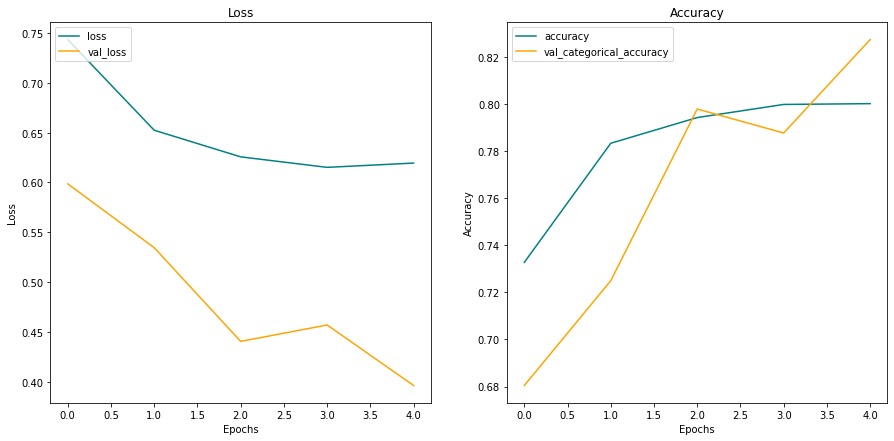

In [17]:
fig = plt.figure(figsize = (15,7))

plt.subplot(1, 2, 1, title = 'Loss')
plt.plot(model_2_df['loss'], 
         color = 'teal', 
         label = 'loss')
plt.plot(model_2_df['val_loss'], 
         color = 'orange', 
         label = 'val_loss')
plt.legend(loc = "upper left")
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2, title = 'Accuracy')
plt.plot(model_2_df['categorical_accuracy'], 
         color = 'teal', 
         label = 'accuracy')
plt.plot(model_2_df['val_categorical_accuracy'], 
         color = 'orange', 
         label = 'val_categorical_accuracy')
plt.legend(loc = "upper left")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

#plt.subplots_adjust(wspace=1)
plt.show()

Evaluate model

In [25]:
df_test = \
pd.read_csv(
    '/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv', 
    dtype = str)

# a new column called labels_ was created wherein 'all' patients are labelled 'all' 
df_test.loc[df_test['Patient_ID'].str.contains('all'), 'true_labels'] = 'all'

# a new column called labels_ was created wherein healthy patients are labelled 'hem' 
df_test.loc[df_test['Patient_ID'].str.contains('hem'), 'true_labels'] = 'hem'

df_test

,Patient_ID,new_names,labels,true_labels
0,UID_57_29_1_all.bmp,1.bmp,1,all
1,UID_57_22_2_all.bmp,2.bmp,1,all
2,UID_57_31_3_all.bmp,3.bmp,1,all
3,UID_H49_35_1_hem.bmp,4.bmp,0,hem
4,UID_58_6_13_all.bmp,5.bmp,1,all
...,...,...,...,...
1862,UID_54_33_1_all.bmp,1863.bmp,1,all
1863,UID_55_24_1_all.bmp,1864.bmp,1,all
1864,UID_H32_20_1_hem.bmp,1865.bmp,0,hem
1865,UID_54_30_2_all.bmp,1866.bmp,1,all


In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = \
test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = \
    '/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data',
    batch_size = 100,
    target_size = (480,480),
    x_col = 'new_names',
    y_col = 'true_labels',
    color_mode = 'rgb',
    class_mode = 'categorical')

X_test, y_test = test_generator.next()

Found 1867 validated image filenames belonging to 2 classes.


In [32]:
score_2 = model_2.evaluate(X_test, y_test)

print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

4/4 [==============================] - 3s 450ms/step - loss: 1.4731 - categorical_accuracy: 0.3000


[1.4730677604675293, 0.30000001192092896]

In [33]:
# Calculate the predictions
predict_probas_2 = model_2.predict(X_test) 

# Convert probabilities to label encoding
y_predict_2 = np.argmax(predict_probas_2, axis=1)

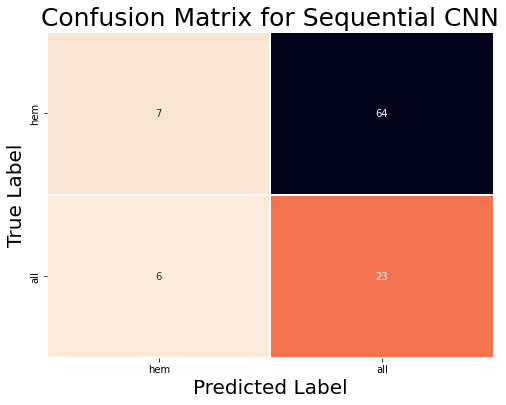

In [34]:
y_test_labels = np.argmax(y_test, axis=1)
conf_mat_2 = confusion_matrix(y_test_labels, y_predict_2)

plt.figure(figsize = (8,6))
sns.heatmap(conf_mat_2,
            annot = True,
            cbar = False,
            xticklabels = val_ds.class_names,
            yticklabels = val_ds.class_names,
            cmap = "rocket_r",
            linewidths = 1)
plt.title('Confusion Matrix for Sequential CNN', 
          size = 25, 
          y = 1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()